<a href="https://colab.research.google.com/github/Leinadh/avatar-image-generator/blob/master/xgan_stev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGAN: Unsupervised Image-to-Image Translation for Many-to-Many Mapping Problems**

Implementation of XGAN model for automatic cartoon generation from real faces. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 163kB 16.7MB/s 
     |████████████████████████████████| 102kB 7.6MB/s 
     |████████████████████████████████| 122kB 17.2MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=b70bf79dde724a91e9e13689d887e2dd160c3922f9effed975038f4e3b4d940d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=ac34e5d4a2bf2b082c87919fd6a1f09c465f58acfdcc675c0d29043a61e3387d
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=e6e2893342cddfcc363a65d6b93d0421789b0f2dad6da6

In [3]:
!wandb login 17d2772d85cbda79162bd975e45fdfbf3bb18911

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
!git clone https://github.com/Leinadh/avatar-image-generator.git

Cloning into 'avatar-image-generator'...
remote: Enumerating objects: 33068, done.
remote: Total 33068 (delta 0), reused 0 (delta 0), pack-reused 33068
Receiving objects: 100% (33068/33068), 1.37 GiB | 15.09 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Checking out files: 100% (33638/33638), done.


In [5]:
!rm -r avatar-image-generator/datasets/face_datasets/face_images_wo_bg/ avatar-image-generator/datasets/face_datasets/vgg_face_dataset/
!rm -r avatar-image-generator/datasets/cartoon_datasets/*.csv avatar-image-generator/datasets/cartoon_datasets/cartoonset100k_limited/

In [6]:
#!cd avatar-image-generator/; git pull

In [7]:
import wandb

In [8]:
wandb.init(project="avatar_image_generator")
wandb.watch_called = False

wandb: Currently logged in as: stevramos (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200928_073208-1b9k0zez
wandb: Syncing run rose-water-1


In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from PIL import Image

import logging



In [10]:
def configure_model():

  config = wandb.config 

  config.seed = 0
  ### hyperparameters ###

  config.batch_size = 32
  config.image_size = 64
  config.use_gpu = True
  config.workers = 4

  config.dropout_rate_eshared = 0.5
  config.dropout_rate_cdann = 0.5

  config.learning_rate_opTotal = 1e-4

  config.learning_rate_opDisc = 1e-3
  config.b1_disc = 0.5

  config.learning_rate_opCdann = 1e-3
  config.b1_cdann = 0.99

  config.learning_rate_denoiser = 1e-3

  config.ws = 0.5
  config.wg = 0.7

  config.num_epochs = 700

  return config

In [11]:
# cambiar esto

config = configure_model()

In [12]:
torch.manual_seed(config.seed)
np.random.seed(config.seed)

## Preprocessing images - faces

In [13]:
import cv2
import helper

(254, 222, 3)


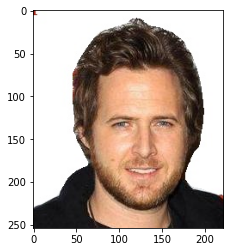

In [14]:
path_faces = '/content/avatar-image-generator/datasets/face_datasets/face_images_wo_bg_permissive/'

img = cv2.imread(path_faces + 'A.J._Buckley_1_wo_bg.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)
plt.show()

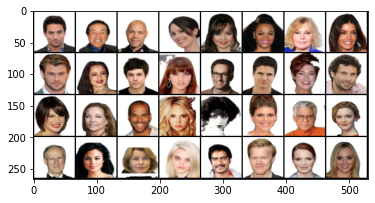

In [15]:
path_faces = '/content/avatar-image-generator/datasets/face_datasets/'

transform = transforms.Compose([
                transforms.Resize((config.image_size,config.image_size)) ,
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataset_faces = torchvision.datasets.ImageFolder(path_faces, transform=transform)

train_dataset_faces, test_dataset_faces = torch.utils.data.random_split(dataset_faces,
                                                                                (int(len(dataset_faces)*0.9),len(dataset_faces) - int(len(dataset_faces)*0.9)))


train_loader_faces = torch.utils.data.DataLoader(
    train_dataset_faces,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.workers)

test_loader_faces = torch.utils.data.DataLoader(
    test_dataset_faces,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.workers)

dataiter = iter(train_loader_faces)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0))

# Preprocessing cartoons

(500, 500, 3)


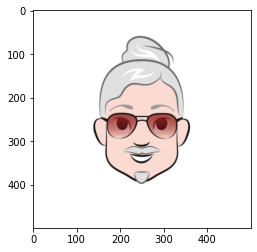

In [16]:
path_cartoons = '/content/avatar-image-generator/datasets/cartoon_datasets/cartoonset10k/'

img = cv2.imread(path_cartoons + 'cs10000053986926948907.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)
plt.show()

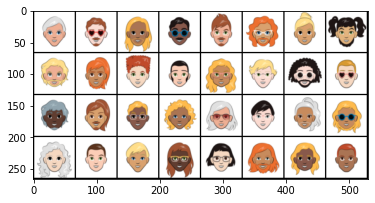

In [17]:
path_cartoons = '/content/avatar-image-generator/datasets/cartoon_datasets/'

transform = transforms.Compose([
                transforms.CenterCrop(400),
                transforms.Resize((config.image_size,config.image_size)) ,
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])


dataset_cartoons = torchvision.datasets.ImageFolder(path_cartoons, transform=transform)

train_dataset_cartoons, test_dataset_cartoons = torch.utils.data.random_split(dataset_cartoons,
                                                                                (int(len(dataset_cartoons)*0.9),len(dataset_cartoons) - int(len(dataset_cartoons)*0.9)))


train_loader_cartoons = torch.utils.data.DataLoader(
    train_dataset_cartoons,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.workers)

test_loader_cartoons = torch.utils.data.DataLoader(
    test_dataset_cartoons,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.workers)

dataiter = iter(train_loader_cartoons)
images_cartoon = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

## XGAN Model

### Classes

In [18]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b1 = nn.BatchNorm2d(32) 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False) #out: 16 x 16 x 64
    self.b2 = nn.BatchNorm2d(64) 

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = self.b1(x)
    x = F.relu(self.conv2(x))
    x = self.b2(x)

    return x  


class Eshared(nn.Module):
  def __init__(self, dropout_rate):
    super(Eshared, self).__init__()
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False)
    self.b3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False)
    self.b4 = nn.BatchNorm2d(256)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*256, out_features = 1024, bias=False)
    self.bfc1 = nn.BatchNorm1d(1024)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.fc2 = nn.Linear(in_features = 1024, out_features = 1024, bias=False)
    self.bfc2 = nn.BatchNorm1d(1024)

  def forward(self,x):
    x = F.relu(self.conv3(x))
    x = self.b3(x)
    x = F.relu(self.conv4(x))
    x = self.b4(x)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.bfc1(x)
    x = self.dropout2(x)      
    x = F.relu(self.fc2(x))
    x = self.bfc2(x) 

    return x
    

class Dshared(nn.Module):
  def __init__(self):
    super(Dshared, self).__init__()
    #c = capacity
    self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, bias=False)
    self.bd1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, bias=False)
    self.bd2 = nn.BatchNorm2d(256)
  
  def forward(self,x):
    x = x.view(-1,1024,1,1)
    x = F.relu(self.deconv1(x))
    x = self.bd1(x)
    x = F.relu(self.deconv2(x))
    x = self.bd2(x)

    return x

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, bias=False)
    self.bd3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, bias=False)
    self.bd4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = self.bd3(x)
    x = F.relu(self.deconv4(x))
    x = self.bd4(x)
    x = torch.tanh(self.deconv5(x))

    return x


class GradReverse(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x):
    return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
    return grad_output.neg() * 0.5


def grad_reverse(x):
  return GradReverse.apply(x)


class Cdann(nn.Module):
  def __init__(self, dropout_rate):
    super(Cdann, self).__init__()
    self.fc1 = nn.Linear(in_features = 1024, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512 , out_features = 256)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.fc3 = nn.Linear(in_features = 256 , out_features = 128)
    self.fc4 = nn.Linear(in_features = 128 , out_features = 64)
    self.dropout4 = nn.Dropout(dropout_rate)
    self.fc5 = nn.Linear(in_features = 64 , out_features = 32)
    self.fc6 = nn.Linear(in_features = 32 , out_features = 16)
    self.dropout6 = nn.Dropout(dropout_rate)
    self.fc7 = nn.Linear(in_features = 16, out_features = 1)

  def forward(self, x):
    x = grad_reverse(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.dropout4(x)
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = self.dropout6(x)
    x = torch.sigmoid(self.fc7(x))

    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32 
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b3 = nn.BatchNorm2d(32)  
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32 
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*32, out_features = 1)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.b2(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.b3(x)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = self.flatten(x)
    x = torch.sigmoid(self.fc1(x))

    return x

class Denoiser(nn.Module):
  def __init__(self):
    super(Denoiser, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))
    
    self.decoder = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 3, kernel_size=3, padding=1))
    
  def forward(self,x):
    return self.decoder(self.encoder(x))

### Losses functions

In [19]:
def Lrec(image_rec, image_orig):

  image_rec_r = image_rec.view(-1,64*64*3)
  image_orig_r = image_orig.view(-1,64*64*3)
  #mse
  rec_loss = torch.norm(image_rec_r - image_orig_r, p=2, dim=1)
  rec_loss = torch.mean(rec_loss)


  return rec_loss


def Lsem(encoder,encoder_rec):

  encoder = encoder.view(-1,1024)
  encoder_rec = encoder_rec.view(-1,1024)

  sem_loss = torch.norm(encoder - encoder_rec, p=1, dim=1)
  
  sem_loss = torch.mean(sem_loss)

  return sem_loss 


## Utils

In [20]:
def init_logger(log_file=None, log_dir=None):
  
  fmt = '%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s: %(message)s'

  if log_dir is None:
    log_dir = '~/temp/log/'

  if not os.path.exists(log_dir):
        print("Creating dir")
        os.makedirs(log_dir)

  log_file = os.path.join(log_dir, log_file)

  print('log file path:' + log_file)

  logging.basicConfig(level=logging.INFO,
                      filename=log_file,
                      format=fmt)
  
  
  return logging  

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #print('Applied to:: ', m.__class__.__name__)
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.kaiming_uniform_(m.weight.data )
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_weights(path_gen, path_sub, n):
  
  torch.save(e1.state_dict(), os.path.join(path_sub, 'e1.pth'))
  torch.save(e2.state_dict(), os.path.join(path_sub, 'e2.pth'))
  torch.save(e_shared.state_dict(), os.path.join(path_sub, 'e_shared.pth'))
  torch.save(d_shared.state_dict(), os.path.join(path_sub, 'd_shared.pth'))
  torch.save(d1.state_dict(), os.path.join(path_sub, 'd1.pth'))
  torch.save(d2.state_dict(), os.path.join(path_sub, 'd2.pth'))
  torch.save(c_dann.state_dict(), os.path.join(path_sub, 'c_dann.pth'))
  torch.save(discriminator1.state_dict(), os.path.join(path_sub, 'disc1.pth'))
  torch.save(denoiser.state_dict(), os.path.join(path_sub, 'denoiser.pth'))

  wandb.save(os.path.join(path_sub,'*.pth'),base_path='/'.join(path_gen.split('/')[:-2]))


## GPU

In [22]:
print("it is cuda available? ", torch.cuda.is_available())
device = torch.device("cuda:0" if config.use_gpu and torch.cuda.is_available() else "cpu")

it is cuda available?  True


## Training

In [23]:
#change the path save weighs
save_cp = True

if save_cp:
  path_save_weights = "/content/drive/My Drive/Made with ML/weights_train_stev_v6/"

  try:
      os.mkdir(path_save_weights)
  except OSError:
      pass

In [24]:
logging = init_logger(log_file='logfile.log',log_dir=path_save_weights)

log file path:/content/drive/My Drive/Made with ML/weights_train_stev_v6/logfile.log


In [25]:
def train(config, model, device, train_loader_faces, train_loader_cartoons, optimizers, criterion_bc, criterionDenoiser):
  
  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model
  optimizerDenoiser, optimizerDisc1, optimizerTotal, optimizerCdann = optimizers 
  
  e1.train()
  e2.train()
  e_shared.train()
  d_shared.train()
  d1.train()
  d2.train()
  c_dann.train()
  discriminator1.train()
  denoiser.train()

  for faces_batch, cartoons_batch in zip(train_loader_faces, train_loader_cartoons):

    faces_batch,_ = faces_batch
    faces_batch = Variable(faces_batch.type(torch.Tensor))
    class_faces = Variable(torch.ones(faces_batch.size(0)))
    faces_batch = faces_batch.to(device)
    class_faces = class_faces.to(device)
    
    cartoons_batch,_ = cartoons_batch
    cartoons_batch = Variable(cartoons_batch.type(torch.Tensor))
    class_cartoons = Variable(torch.zeros(cartoons_batch.size(0)))
    cartoons_batch = cartoons_batch.to(device)
    class_cartoons = class_cartoons.to(device)
    
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d1.zero_grad()
    d2.zero_grad()
    c_dann.zero_grad()
    discriminator1.zero_grad()
    denoiser.zero_grad()

    #architecture
    faces_enc1 = e1(faces_batch)
    faces_encoder = e_shared(faces_enc1)
    faces_decoder = d_shared(faces_encoder)
    faces_rec = d1(faces_decoder)
    cartoons_construct = d2(faces_decoder)
    cartoons_construct_enc2 = e2(cartoons_construct)
    cartoons_construct_encoder = e_shared(cartoons_construct_enc2)

    cartoons_enc2 = e2(cartoons_batch)
    cartoons_encoder = e_shared(cartoons_enc2)
    cartoons_decoder = d_shared(cartoons_encoder)
    cartoons_rec = d2(cartoons_decoder)
    faces_construct = d1(cartoons_decoder)
    faces_construct_enc1 = e1(faces_construct)
    faces_construct_encoder = e_shared(faces_construct_enc1)


    # Denoiser
    cartoons_denoised = denoiser(cartoons_rec.detach())

    # Train Denoiser

    loss_denoiser = criterionDenoiser(cartoons_batch, cartoons_denoised)
    loss_denoiser.backward()
    optimizerDenoiser.step()



    #discriminator face(1)->cartoon(2)

      #train discriminator
    data_cartoons = torch.cat([cartoons_batch, cartoons_construct.detach()], 0)
    label_class = torch.cat([class_cartoons, class_faces], 0)   
    output = discriminator1(data_cartoons) 
    loss_disc1 = criterion_bc(output.squeeze(), label_class)
    loss_disc1.backward()
    optimizerDisc1.step()

    #train generator
    data_classifier = torch.cat([faces_encoder, cartoons_encoder], 0)
    label_classifier = torch.cat([class_faces, class_cartoons], 0)

    label_output = c_dann(data_classifier) 


    loss_rec1 = Lrec(faces_batch, faces_rec)
    loss_rec2 = Lrec(cartoons_batch, cartoons_rec)
    loss_rec =  loss_rec1 + loss_rec2

    error_classifier = criterion_bc(label_output.squeeze(),label_classifier) 

    loss_sem1 = Lsem(faces_encoder.detach(), cartoons_construct_encoder) 
    loss_sem2 = Lsem(cartoons_encoder.detach(), faces_construct_encoder) 
    loss_sem = loss_sem1 + loss_sem2

          
    class_faces.fill_(0)

    output = discriminator1(cartoons_construct)

    loss_gen1 = criterion_bc(output.squeeze(), class_faces)



    loss_total = loss_rec + error_classifier + config.ws*loss_sem + config.wg*loss_gen1
    loss_total.backward()


    optimizerTotal.step()
    optimizerCdann.step()


  return loss_rec1, loss_rec2, error_classifier,loss_sem1, loss_sem2, loss_disc1, loss_gen1, loss_total, loss_denoiser

In [26]:
def test_image(model, device, images_faces):

  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model

  e1.eval()
  e2.eval()
  e_shared.eval()
  d_shared.eval()
  d1.eval()
  d2.eval()
  c_dann.eval()
  discriminator1.eval()
  denoiser.eval()

  with torch.no_grad():
      output = e1(images_faces[0].to(device))
      output = e_shared(output)
      output = d_shared(output)
      output = d2(output)
      output = denoiser(output)
    

  # generated_images = torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0)

  return output.cpu()

In [27]:
def init_optimizers(model, config):

  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model

  listDisc1 = list(discriminator1.parameters())
  optimizerDisc1 = torch.optim.Adam(listDisc1, lr=config.learning_rate_opDisc, betas=(config.b1_disc, 0.999))

  listParameters = list(e1.parameters()) + list(e2.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d1.parameters()) + list(d2.parameters())
  optimizerTotal = torch.optim.RMSprop(listParameters, lr=config.learning_rate_opTotal, weight_decay=0.01)

  optimizerCdann = torch.optim.Adam(c_dann.parameters(), lr=config.learning_rate_opCdann, betas=(config.b1_cdann, 0.999))

  optimizerDenoiser = torch.optim.Adam(denoiser.parameters(), lr=config.learning_rate_denoiser)

  return (optimizerDenoiser, optimizerDisc1, optimizerTotal, optimizerCdann) 

In [28]:
def init_model(device, config, use_wandb=True):

  e1 = Encoder()
  e2 = Encoder()
  e_shared = Eshared(config.dropout_rate_eshared)
  d_shared = Dshared()
  d1 = Decoder()
  d2 = Decoder()
  c_dann = Cdann(config.dropout_rate_cdann)
  discriminator1 = Discriminator()
  denoiser = Denoiser()

  e1.to(device)
  e2.to(device)
  e_shared.to(device)
  d_shared.to(device)
  d1.to(device)
  d2.to(device)
  c_dann.to(device)
  discriminator1.to(device)
  denoiser = denoiser.to(device)
  
  e1.apply(weights_init)
  e2.apply(weights_init)
  e_shared.apply(weights_init)
  d_shared.apply(weights_init)
  d1.apply(weights_init)
  d2.apply(weights_init)
  c_dann.apply(weights_init)
  discriminator1.apply(weights_init)
  denoiser.apply(weights_init)

  if use_wandb:
    wandb.watch(e1, log="all")
    wandb.watch(e2, log="all")
    wandb.watch(e_shared, log="all")
    wandb.watch(d_shared, log="all")
    wandb.watch(d1, log="all")
    wandb.watch(d2, log="all")
    wandb.watch(c_dann, log="all")
    wandb.watch(discriminator1, log="all")
    wandb.watch(denoiser, log="all")

  return (e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser)


In [29]:
def model_train(config, device, train_loader_faces, test_loader_faces, train_loader_cartoons):

  model = init_model(device, config)
  optimizers = init_optimizers(model, config)

  train_loss_rec1 = []
  train_loss_rec2 = []
  train_loss_cdan = []
  train_loss_sem1 = []
  train_loss_sem2 = []
  train_disc1 = []
  train_gen1 = []
  train_loss_total = []
  train_loss_denoiser = []

  criterion_bc = nn.BCELoss()
  criterionDenoiser = nn.L1Loss()

  criterion_bc.to(device) 
  criterionDenoiser.to(device) 

  dataiter = iter(test_loader_faces)
  images_faces_to_test = dataiter.next()

  for epoch in tqdm(range(config.num_epochs)):
    loss_rec1, loss_rec2, error_classifier,loss_sem1, loss_sem2, loss_disc1, loss_gen1, loss_total, loss_denoiser = train(config, model, device, train_loader_faces, train_loader_cartoons, optimizers, criterion_bc, criterionDenoiser)
    generated_images = test_image(model, device, images_faces_to_test)


    logging.info('Train Epoch [{}/{}], Loss rec1: {:.4f}, Loss rec2: {:.4f},'
                                      ' Loss classifier: {:.4f}, Loss semantic 1->2: {:.4f}, Loss semantic 2->1: {:.4f},'
                                      ' Loss disc1: {:.4f}, Loss gen1: {:.4f}, Loss total: {:.4f}'
                                      .format(epoch+1, config.num_epochs, loss_rec1.item(),
                                              loss_rec2.item(), error_classifier.item(),
                                              loss_sem1.item(), loss_sem2.item(),
                                              loss_disc1.item(), loss_gen1.item(), loss_total.item()))

    wandb.log({"train_epoch":epoch+1,
               "Generated images": [wandb.Image(img) for img in generated_images],
              "loss_rec1":loss_rec1.item(),
              "loss_rec2":loss_rec2.item(),
              "loss_classifier":error_classifier.item(),
              "loss_semantic12":loss_sem1.item(),
              "loss_semantic21":loss_sem2.item(),
              "loss_disc1":loss_disc1.item(),
              "loss_gen1":loss_gen1.item(),
              "loss_total":loss_total.item()})


    if save_cp and ((epoch+1)%25)==0:
      path_save_epoch = path_save_weights + 'epoch_{}'.format(epoch+1)
      try:
          os.mkdir(path_save_epoch)
      except OSError:
          pass
      save_weights(path_save_weights, path_save_epoch, epoch)    
      logging.info(f'Checkpoint {epoch + 1} saved !')

    train_loss_rec1.append(loss_rec1.item())
    train_loss_rec2.append(loss_rec2.item())
    train_loss_cdan.append(error_classifier.item())
    train_loss_sem1.append(loss_sem1.item())
    train_loss_sem2.append(loss_sem2.item())
    train_disc1.append(loss_disc1.item())
    train_gen1.append(loss_gen1.item())
    train_loss_total.append(loss_total.item())
    train_loss_denoiser.append(loss_denoiser.item())

    print("Losses")
    print('Epoch [{}/{}], Loss rec1: {:.4f}'.format(epoch+1, config.num_epochs, loss_rec1.item()))
    print('Epoch [{}/{}], Loss rec2: {:.4f}'.format(epoch+1, config.num_epochs, loss_rec2.item()))
    print('Epoch [{}/{}], Loss classifier: {:.4f}'.format(epoch+1, config.num_epochs, error_classifier.item()))
    print('Epoch [{}/{}], Loss semantic 1->2: {:.4f}'.format(epoch+1, config.num_epochs, loss_sem1.item()))
    print('Epoch [{}/{}], Loss semantic 2->1: {:.4f}'.format(epoch+1, config.num_epochs, loss_sem2.item()))    
    print('Epoch [{}/{}], Loss disc1: {:.4f}'.format(epoch+1, config.num_epochs, loss_disc1.item()))
    print('Epoch [{}/{}], Loss gen1: {:.4f}'.format(epoch+1, config.num_epochs, loss_gen1.item()))
    print('Epoch [{}/{}], Loss total: {:.4f}'.format(epoch+1, config.num_epochs, loss_total.item()))
    print('Epoch [{}/{}], Loss denoiser: {:.4f}'.format(epoch+1, config.num_epochs, loss_denoiser.item()))

In [ ]:
model_train(config, device, train_loader_faces, test_loader_faces, train_loader_cartoons)

Losses
Epoch [1/700], Loss rec1: 122.0447
Epoch [1/700], Loss rec2: 130.1321
Epoch [1/700], Loss classifier: 0.6256
Epoch [1/700], Loss semantic 1->2: 874.7820
Epoch [1/700], Loss semantic 2->1: 732.6044
Epoch [1/700], Loss disc1: 0.0425
Epoch [1/700], Loss gen1: 0.8722
Epoch [1/700], Loss total: 1057.1061
Epoch [1/700], Loss denoiser: 0.2685
Losses
Epoch [2/700], Loss rec1: 120.4488
Epoch [2/700], Loss rec2: 123.7982
Epoch [2/700], Loss classifier: 0.3861
Epoch [2/700], Loss semantic 1->2: 691.7399
Epoch [2/700], Loss semantic 2->1: 615.9471
Epoch [2/700], Loss disc1: 0.0050
Epoch [2/700], Loss gen1: 0.6215
Epoch [2/700], Loss total: 898.9117
Epoch [2/700], Loss denoiser: 0.2191
Losses
Epoch [3/700], Loss rec1: 106.1634
Epoch [3/700], Loss rec2: 112.3774
Epoch [3/700], Loss classifier: 0.3512
Epoch [3/700], Loss semantic 1->2: 503.7367
Epoch [3/700], Loss semantic 2->1: 469.9510
Epoch [3/700], Loss disc1: 0.0045
Epoch [3/700], Loss gen1: 0.5643
Epoch [3/700], Loss total: 706.1309
Epoc

## Validating model

In [ ]:
def load_weights_xgan(path_load_weights, e1, e2, e_shared, d_shared, d1, d2, denoiser):
  
  e1.load_state_dict(torch.load(path_load_weights + 'e1.pth'))
  e2.load_state_dict(torch.load(path_load_weights + 'e2.pth'))
  e_shared.load_state_dict(torch.load(path_load_weights + 'e_shared.pth'))
  d_shared.load_state_dict(torch.load(path_load_weights + 'd_shared.pth'))
  d1.load_state_dict(torch.load(path_load_weights + 'd1.pth'))
  d2.load_state_dict(torch.load(path_load_weights + 'd2.pth'))
  denoiser.load_state_dict(torch.load(path_load_weights + 'denoiser.pth'))

  return

In [ ]:
e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = init_model(device, config, use_wandb=False)

In [ ]:
  e1.eval()
  e2.eval()
  e_shared.eval()
  d_shared.eval()
  d1.eval()
  d2.eval()
  c_dann.eval()
  discriminator1.eval()
  denoiser.eval()

In [ ]:
use_weights_just_trained = True

if not use_weights_just_trained:
  path_load_weights = "/content/drive/My Drive/Made with ML/weights_train_stev_v6/epoch_700/"
  load_weights_xgan(path_load_weights, e1, e2, e_shared, d_shared, d1, d2, denoiser)



### Faces domain

#### Original faces

In [ ]:
dataiter = iter(test_loader_faces)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0))

#### Rec faces

In [ ]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  

plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

#### Face to cartoon

In [ ]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
    output = denoiser(output)
  


plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

### Cartoons domain

#### Original cartoons

In [ ]:
dataiter = iter(test_loader_cartoons)
images_cartoon = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

#### Rec cartoon


In [ ]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
    output = denoiser(output)


plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

#### Cartoon to face

In [ ]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

## Testing model

In [ ]:
!pip install keras-segmentation

In [ ]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12
import cv2
import os

In [ ]:
def remove_background(img_mask, img1, output_path, output_file):


  seg_gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
  #_,fg_mask = cv2.threshold(seg_gray, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
  _,bg_mask = cv2.threshold(seg_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

  ## convert mask to 3-channels
  #fg_mask = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
  bg_mask = cv2.cvtColor(bg_mask, cv2.COLOR_GRAY2BGR)

  ## cv2.bitwise_and to extract the region
  #fg = cv2.bitwise_or(img, fg_mask)
  bg = cv2.bitwise_or(img1, bg_mask)

  ## save 
  ##cv2.imwrite("fg.jpg", fg)
  
  # bg = cv2.cvtColor(bg, cv2.COLOR_RGB2BGR)
  
  cv2.imwrite(output_path + output_file, bg)


In [ ]:
model = pspnet_101_voc12()

In [ ]:
#remove background
path = '/content/drive/My Drive/Made with ML/datasets/faces_pucp/data/'
mask_path = '/content/masks/images/'
output_path = '/content/faces_people_wo_bg/images/'

dir_path = os.path.dirname(mask_path)
if not os.path.exists(dir_path):
  os.makedirs(dir_path)

dir_path = os.path.dirname(output_path)
if not os.path.exists(dir_path):
  os.makedirs(dir_path)


for filename in tqdm(os.listdir(path)):
  # filename = filename.split('/')[1] 
  mask_file = filename.split('.')[0] + "_mask.png"
  output_file = filename.split('.')[0] + "_wo_bg.jpg"



  #img1 = cv2.imread(path + filename) #READ BGR

  #if (img1.shape != 3): 
   # continue

  #else:

  out = model.predict_segmentation(
    inp= path + filename,
    out_fname= mask_path + mask_file
  )
  
  img_mask = cv2.imread(mask_path + mask_file)
  img1 = cv2.imread(path + filename) #READ BGR

  remove_background(img_mask, img1, output_path, output_file)

In [ ]:
path_test_images = '/content/faces_people_wo_bg/'

transform = transforms.Compose([
                               
                transforms.Resize((config.image_size,config.image_size)) ,
                transforms.CenterCrop(64), 
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataset_test_images = torchvision.datasets.ImageFolder(path_test_images, transform=transform)

test_loader_images = torch.utils.data.DataLoader(
    dataset_test_images,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.workers)

dataiter = iter(test_loader_images)
test_images = dataiter.next()


plt.imshow(torchvision.utils.make_grid(test_images[0]).permute(1, 2, 0))

In [ ]:
input_img = test_images[0]
x = torch.cat(8*[input_img])
x.shape

In [ ]:
plt.imshow(torchvision.utils.make_grid(x).permute(1, 2, 0))

In [ ]:
with torch.no_grad():
    output = e1(x.to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
    output = denoiser(output)
  

plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

In [ ]:
with torch.no_grad():
    output = e1(test_images[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
    output = denoiser(output)

plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()